In [1]:
# Avner Khan, Kiran Raja, Abhishek Khare, Joshua Deng
import matplotlib.pyplot as plt
from amb_sdk.sdk import DarwinSdk
from time import sleep
import pandas as pd
import numpy as np
import sklearn.model_selection as ms
from sklearn.metrics import classification_report
import datetime

ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())


In [2]:
#Create a new user
status, msg = ds.auth_login_user('AVNERKHAN@UTEXAS.edu', 'xcGPvw7VMm')
if not status:
    print(msg)
print(status)

True


In [3]:
def elapsed_time(oc_date, oc_time, rep_date, rep_time):
    oc_date_split_arr = oc_date.split("/")
    oc_date_month = oc_date_split_arr[0]
    oc_date_day = oc_date_split_arr[1]
    oc_date_year = oc_date_split_arr[2]
    oc_hr = int(oc_time // 100)
    if (oc_hr > 23):
        oc_hr = 23
    elif (oc_hr < 0):
        oc_hr = 0
    oc_min = int(oc_time % 100)
    if (oc_min > 59):
        oc_min = 59
    elif (oc_min < 0):
        oc_min = 0
    oc_datetime = datetime.datetime(int(oc_date_year), int(oc_date_month), int(oc_date_day), oc_hr, oc_min)
    rep_date_split_arr = rep_date.split("/")
    rep_date_month = rep_date_split_arr[0]
    rep_date_day = rep_date_split_arr[1]
    rep_date_year = rep_date_split_arr[2]
    rep_hr = int(rep_time // 100)
    if (rep_hr > 23):
        rep_hr = 23
    elif (rep_hr < 0):
        rep_hr = 0
    rep_min = int(rep_time % 100)
    if (rep_min > 59):
        rep_min = 59
    elif (rep_min < 0):
        rep_min = 0
    rep_datetime = datetime.datetime(int(rep_date_year), int(rep_date_month), int(rep_date_day), rep_hr, rep_min)
    elapsed = rep_datetime - oc_datetime
    return elapsed.total_seconds() / 3600

#Load data
dataset = pd.read_csv("Crime_Reports_Fixed_Labels.csv")
print('Original Length:', len(dataset))
print('Original Features:', list(dataset))
#Drop Unused Columns
dataset = dataset.drop(columns=['Location', 'Category Description', 'UCR Category', 'PRA', 'APD Sector', 'APD District', 'Council District', 'Zip Code', 'Address', 'Incident Number', 'Highest Offense Description', 'Occurred Date Time', 'Report Date Time', 'Clearance Date', 'X-coordinate', 'Y-coordinate', 'Latitude', 'Longitude', 'Single Member Council Districts', 'BOUNDARIES_single_member_districts', 'Zoning Review Cases_data'])
#Drop rows with missing data
dataset = dataset.dropna()
#Create Elapsed Time Field and add it to our data
elapsed = []
for index, row in dataset.iterrows():
    elapsed.append(elapsed_time(row['Occurred Date'], row['Occurred Time'], row['Report Date'], row['Report Time']))
elapsed_df = pd.DataFrame(data=elapsed)
dataset['Elapsed Time'] = elapsed_df
dataset = dataset.drop(columns=['Occurred Date', 'Occurred Time', 'Report Date', 'Report Time'])
#Drop rows with missing data
dataset = dataset.dropna()
#Print Cleaned Data and save it as csv
print()
print('Cleaned Length:', len(dataset))
print('Remaining Features:', list(dataset))
print(dataset.head())
dataset.to_csv("Crime_Reports_Clean.csv", index=False)

C:\Users\kiran\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Original Length: 2124418
Original Features: ['Incident Number', 'Highest Offense Description', 'Highest Offense Code', 'Family Violence', 'Occurred Date Time', 'Occurred Date', 'Occurred Time', 'Report Date Time', 'Report Date', 'Report Time', 'Location Type', 'Address', 'Zip Code', 'Council District', 'APD Sector', 'APD District', 'PRA', 'Census Tract', 'Clearance Status', 'Clearance Date', 'UCR Category', 'Category Description', 'X-coordinate', 'Y-coordinate', 'Latitude', 'Longitude', 'Location', 'Zip Codes', 'Single Member Council Districts', 'BOUNDARIES_single_member_districts', 'Zoning Review Cases_data']

Cleaned Length: 1208611
Remaining Features: ['Highest Offense Code', 'Family Violence', 'Location Type', 'Census Tract', 'Clearance Status', 'Zip Codes', 'Elapsed Time']
    Highest Offense Code Family Violence                 Location Type  \
2                   2716               N                   RESTAURANTS   
3                   2716               N   DEPARTMENT / DISCOUN

In [4]:
#Split and Save Train and Test Data
dataset = pd.read_csv("Crime_Reports_Clean.csv")
dataset = dataset.sample(frac=1)
train_data = dataset.iloc[:int(len(dataset)*.8)]
test_data = dataset.iloc[int(len(dataset)*.8):]
print('Train Data:', len(train_data))
print(train_data.head())
print()
print('Test Data:', len(test_data))
print(test_data.head())
train_data.to_csv("Crime_Reports_Train.csv", index=False)
test_data.to_csv("Crime_Reports_Test.csv", index=False)

Train Data: 966888
        Highest Offense Code Family Violence                 Location Type  \
546974                  4100               N              RESIDENCE / HOME   
213318                   600               N   DEPARTMENT / DISCOUNT STORE   
568073                   600               N              RESIDENCE / HOME   
777625                  1800               N  STREETS / HWY / ROAD / ALLEY   
973614                  1400               N         PARKING LOTS / GARAGE   

        Census Tract Clearance Status  Zip Codes  Elapsed Time  
546974         18.05                N     3646.0    132.683333  
213318         17.50                N     3638.0      0.033333  
568073         17.45                N     3243.0      0.000000  
777625         21.05                C     3239.0      0.000000  
973614          2.05                N     3644.0      0.000000  

Test Data: 241723
         Highest Offense Code Family Violence  \
87811                    2704               Y   
37689

In [5]:
#Upload Train Data
status, message = ds.delete_dataset("Crime_Reports_Train.csv")
print(status, message)
status, uploaded_dataset = ds.upload_dataset("Crime_Reports_Train.csv")
if not status:
    print(uploaded_dataset)

#Clean Train Data
target = "Clearance Status"
status, job_id = ds.clean_data("Crime_Reports_Train.csv", target = target)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

True None
{'status': 'Requested', 'starttime': '2019-04-20T14:26:05.315836', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': ['22a0bc6cf84345f6a8c503a2f3506993'], 'model_name': None, 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-20T14:26:05.315836', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': ['22a0bc6cf84345f6a8c503a2f3506993'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T14:26:05.315836', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': ['22a0bc6cf84345f6a8c503a2f3506993'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T14:26:05.315836

In [6]:
#Creating Model
model = target + "_model" + ts
status, message = ds.delete_model(model)
print(status, message)
status, job_id = ds.create_model(dataset_names = "Crime_Reports_Train.csv", \
                                 model_name =  model, \
                                 max_train_time = '01:00')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)
    

False 400: BAD REQUEST - {"message": "Model does not exist"}

{'status': 'Requested', 'starttime': '2019-04-20T14:28:26.710665', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190420142147', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-20T14:28:26.710665', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190420142147', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-20T14:28:26.710665', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190420142147', 'job_error': ''}
{'status': 'Runnin

{'status': 'Running', 'starttime': '2019-04-20T14:28:26.710665', 'endtime': None, 'percent_complete': 2, 'job_type': 'TrainModel', 'loss': 0.4462642967700958, 'generations': 0, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190420142147', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T14:28:26.710665', 'endtime': None, 'percent_complete': 2, 'job_type': 'TrainModel', 'loss': 0.4462642967700958, 'generations': 0, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190420142147', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T14:28:26.710665', 'endtime': None, 'percent_complete': 2, 'job_type': 'TrainModel', 'loss': 0.4462642967700958, 'generations': 0, 'dataset_names': ['Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model20190420142147', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20

In [7]:
#Analyzing Models
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-20T15:35:46.949398', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.4200733006000519, 'generations': 6, 'dataset_names': None, 'artifact_names': ['84bc65621352428c93f741dea381a2a9'], 'model_name': 'Clearance Status_model20190420142147', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T15:35:46.949398', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.4200733006000519, 'generations': 6, 'dataset_names': None, 'artifact_names': ['84bc65621352428c93f741dea381a2a9'], 'model_name': 'Clearance Status_model20190420142147', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T15:35:46.949398', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.4200733006000519, 'generations': 6, 'dataset_names': None, 'artifact_names': ['84bc65621352428c93f741dea381a2a9'], 'model_name': 'Clearance Status_model20190420142147', 'job_error': ''}
{'status': 'R

In [8]:
print(feature_importance)

Highest Offense Code                                              5.056567e-01
Location Type = STREETS / HWY / ROAD / ALLEY                      1.364064e-01
Family Violence = Y                                               7.891835e-02
Location Type = RESIDENCE / HOME                                  7.385196e-02
Elapsed Time                                                      4.650376e-02
Census Tract                                                      4.618879e-02
Zip Codes                                                         3.082168e-02
Location Type = DEPARTMENT / DISCOUNT STORE                       2.325520e-02
Location Type = GROCERY / SUPERMARKET                             1.636362e-02
Location Type = PARKING LOTS / GARAGE                             8.583110e-03
Location Type = COMMERCIAL / OFFICE BUILDING                      7.936218e-03
Location Type = OTHER / UNKNOWN                                   5.269813e-03
Location Type = GOVERNMENT / PUBLIC BUILDING        

In [9]:
#Upload Test Data
status, message = ds.delete_dataset("Crime_Reports_Test.csv")
print(status, message)
status, dataset = ds.upload_dataset("Crime_Reports_Test.csv")
if not status:
    print(dataset)
    
#Clean Test Data
status, job_id = ds.clean_data("Crime_Reports_Test.csv", target = target, model_name = model)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

True None
{'status': 'Running', 'starttime': '2019-04-20T15:37:19.740881', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['8e1042e7001b43efb54c3215b5089139'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T15:37:19.740881', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['8e1042e7001b43efb54c3215b5089139'], 'model_name': None, 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T15:37:19.740881', 'endtime': '2019-04-20T15:37:43.740483', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['8e1042e7001b43efb54c3215b5089139'], 'model_name': None, 'job_error': ''}


{'status': 'Running', 'starttime': '2019-04-20T15:39:02.417205', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.4200733006000519, 'generations': 6, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['ce0a5d2e34de4dfca271bed78a24e937'], 'model_name': 'Clearance Status_model20190420142147', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T15:39:02.417205', 'endtime': '2019-04-20T15:39:12.716231', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.4200733006000519, 'generations': 6, 'dataset_names': ['Crime_Reports_Test.csv'], 'artifact_names': ['ce0a5d2e34de4dfca271bed78a24e937'], 'model_name': 'Clearance Status_model20190420142147', 'job_error': ''}
              precision    recall  f1-score   support

           C       0.86      0.81      0.84     73644
           N       0.92      0.94      0.93    168079

   micro avg       0.90      0.90      0.90    241723
   macro avg       0.89      0.88      0.89    241723
weighte

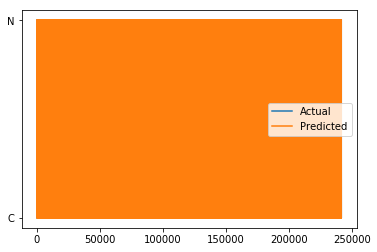

In [10]:
#Run Model on Test Data
status, artifact = ds.run_model("Crime_Reports_Test.csv", model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
df = pd.read_csv("Crime_Reports_Test.csv")
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))

In [11]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

{'type': 'XGBClassifier', 'parameters': {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.7647392976140628, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 17, 'n_estimators': 452, 'n_jobs': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.43197509593085504}}
